# ロジスティック回帰によるL1正則化の検討
UCI Machine Learning RepositoryのWineデータを使って、L1正則化を用いたロジスティック回帰によりWineのクラスラベルを分類する。  
特に、L1正則化のパラメータCを変化さることで、どのように特徴量の重みｗが0になるかの振る舞いを調べる。　　
##### ＜参考資料＞：”Python機械学習プログラミング　第2版（インプレス）”

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

Wineデータをデータフレーム形式で読み込み、訓練データ（70％）とテストデータ（30％）に分割して標準化する

In [2]:
# # Partitioning a dataset into a seperate training and test set

df_wine = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',
    header=None)

# if the Wine dataset is temporarily unavailable from the
# UCI machine learning repository, un-comment the following line
# of code to load the dataset from a local path:

# df_wine = pd.read_csv('wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids',
                   'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

print('Class labels', np.unique(df_wine['Class label']))
print('\n', df_wine.head())

# 特徴量とクラスラベルを別々に抽出
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
# トレーニングデータとテストデータに分割（全体の３０％をテストデータにする）
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# # Bringing features onto the same scale
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

Class labels [1 2 3]

    Class label  Alcohol  Malic acid   Ash  Alcalinity of ash  Magnesium  \
0            1    14.23        1.71  2.43               15.6        127   
1            1    13.20        1.78  2.14               11.2        100   
2            1    13.16        2.36  2.67               18.6        101   
3            1    14.37        1.95  2.50               16.8        113   
4            1    13.24        2.59  2.87               21.0        118   

   Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  \
0           2.80        3.06                  0.28             2.29   
1           2.65        2.76                  0.26             1.28   
2           2.80        3.24                  0.30             2.81   
3           3.85        3.49                  0.24             2.18   
4           2.80        2.69                  0.39             1.82   

   Color intensity   Hue  OD280/OD315 of diluted wines  Proline  
0             5.64  1.04         

In [3]:
# L1正則化ロジスティック回帰のインスタンスを生成（逆正則化パラメータ C=1.0）・・・’ｌ１’はsolverを’saga’にすること
# 正則化を強めて疎性を持たせて０のエントリを増やすには、パラメータｃを小さくする
lr = LogisticRegression(penalty='l1', C=1.0, solver='saga', max_iter=400)

lr.fit(X_train_std, y_train)        # 学習
# トレーニングデータに対する正解率の表示
print('Training accuracy:', lr.score(X_train_std, y_train))
# テストデータに対する正解率の表示
print('Test accuracy:', lr.score(X_test_std, y_test))

# 切片の表示
print( lr.intercept_ )

# 重み係数の表示
np.set_printoptions(8)
lr.coef_[lr.coef_!=0].shape
print( lr.coef_ )

Training accuracy: 1.0
Test accuracy: 1.0
[ 0.51980812  0.62112022 -1.14092835]
[[ 0.04698027  0.          0.         -0.77714262  0.          0.
   0.13485558  0.          0.          0.          0.          0.41226056
   0.87852186]
 [-1.47264606 -0.35453634 -0.92437729  0.          0.          0.
   0.          0.          0.         -1.26139049  0.42499252  0.
  -1.47873048]
 [ 0.          0.          0.          0.          0.          0.
  -2.33470853  0.          0.          0.         -0.79366771 -0.8453443
   0.        ]]


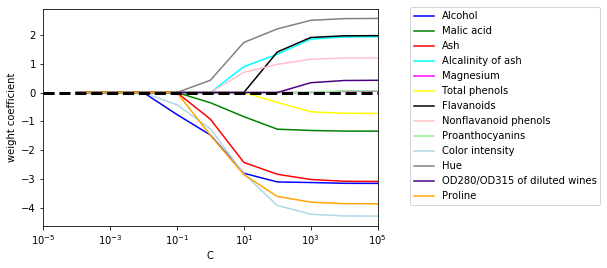

In [4]:
fig = plt.figure()
ax = plt.subplot(111)

colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black',
          'pink', 'lightgreen', 'lightblue', 'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10. ** c, random_state=0, \
                            solver='saga', max_iter=2000)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10 ** c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column], label=df_wine.columns[column + 1],
             color=color)

plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10 ** (-5), 10 ** 5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', bbox_to_anchor=(1.38, 1.03), ncol=1, fancybox=True)
# plt.savefig('images/04_07.png', dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

#### ★グラフから正則化パラメータの強さを高めて（C：正則化パラメータλの逆数、C<0.1）、モデルにペナルティを科した場合、13個の特徴量の重みは全て0になっていることがわかる。